**Calibration of the age-stratified deterministic model**

*Original code by Ryan S. McGee. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

This notebook accompanies our preprint: "*A deterministic, age-stratified, extended SEIRD model for assessing the effect of non-pharmaceutical interventions on SARS-CoV-2 spread in Belgium*"(https://doi.org/10.1101/2020.07.17.20156034)

# Load required packages

In [61]:
import random
import os
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact,fixed,FloatSlider,IntSlider,ToggleButtons
import pandas as pd
import datetime
import scipy
from scipy.integrate import odeint
import matplotlib.dates as mdates
import matplotlib
import scipy.stats as st

import math
import xarray as xr
import emcee
import json

from covid19model.optimization import objective_fcns
from covid19model.optimization import MCMC
from covid19model.models import models
from covid19model.data import google
from covid19model.data import sciensano
from covid19model.data import polymod
from covid19model.data import parameters
from covid19model.visualization.output import population_status, infected
from covid19model.visualization.optimization import plot_fit, traceplot

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
time = '2020-08-01'

In [5]:
start_date='2020-03-15'

In [20]:
checkpoints = {'time':['2020-04-20','2020-05-14'],
        'param': [Nc_home + Nc_work, Nc_home + Nc_schools]}

In [28]:
def date_to_diff(start_date, date):
    return int((pd.to_datetime(date)-pd.to_datetime(start_date))/pd.to_timedelta('1D'))

In [21]:
time_points = [time[0], *checkpoints["time"], time[1]]

In [41]:
for i in range(len(checkpoints["time"])):
    if isinstance(checkpoints["time"][i],str):
        checkpoints["time"][i] = date_to_diff(start_date, checkpoints["time"][i])

# Load data

In [17]:
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = polymod.get_interaction_matrices()
levels = initN.size

In [43]:
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
df_sciensano.tail()

,H_tot,ICU_tot,H_in,H_out,H_tot_cumsum,D_tot,D_25_44,D_45_64,D_65_74,D_75_84,D_85+
DATE,,,,,,,,,,,
2020-08-06,278,65,28,39,687,2,0.0,0.0,0,1.0,1
2020-08-07,285,69,27,28,686,4,0.0,0.0,0,1.0,3
2020-08-08,281,67,31,39,678,2,0.0,0.0,0,2.0,0
2020-08-09,285,69,20,14,684,4,1.0,0.0,0,1.0,2
2020-08-10,312,73,33,12,705,3,0.0,1.0,1,0.0,1


# Initialize the model

In [44]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = parameters.get_COVID19_SEIRD_parameters()
# Add the delayed ramp parameters to the parameter dictionary.
params.update({'l': 1,
              'tau': 5})
# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': np.ones(levels)}
# Load the compliance model
from covid19model.models.compliance import ramp_2
# Initialize the model
model = models.COVID19_SEIRD(initial_states, params, compliance=ramp_2)

# Policies translated to checkpoints

chk_beta_pso = {   
    'time':  [lag_time],    
    'Nc':    [0.2 *Nc_home + ((1-0.70) *Nc_work + (1-0.80) *Nc_transport)],   
}

chk_beta_MCMC = {   
    'time':  [lag_time],   
    'Nc':    [prevention *(1.0 *Nc_home + (1-0.60) *Nc_work + (1-0.70) *Nc_transport +(1-0.30) *Nc_others + (1-0.80) *Nc_leisure)],   
}

chk_beta_MCMC also used for final plot

**Vragen @Tijs**:
- op lag_time dagen, betekent hier dus op 15 maart? (mij zou het veel logischer zijn moest hier een datum staan...
- waarom verschillende Nc op dezelfde dag ingesteld voor de twee calibraties?
- waarschijnlijk moet ik naar tabel 3 kijken van paper? Maar komt er niet mee overeen 
    - bvb 0.2 *Nc_home?
    - waarom enkel home, work en transport matrices voor pso?
    - bvb in tabel staan parameters ingesteld op 17 maart, hierboven zet je checkpoint op 15 maart?
    - checkpoint hierboven komt ook niet overeen met vgl 17 van de paper
    - 0.65 Nc-others komt er niet in voor?
  

# Calibrating $\beta$ and lag_time

**Skip this section when parameters were previously calibrated**

Use the function `fit_pso` to obtain a good starting estimate for the MCMC sampler.

JV: 
- **lag_time = excess time?**
- sigma_H_in = variance on the data (**waarom moet dit geschat worden?**)

In [46]:
start_date = '2020-03-15'

## Initial guess with PSO

In [47]:
# define dataset
data=[df_sciensano["H_in"].values[:8]]
begin_beta = df_sciensano[:8].index.min()
end_beta = df_sciensano[:8].index.max()
# set optimisation settings
parNames = ['sigma_H_in','extraTime','beta'] # must be a list!
states = [["H_in"]]
bounds=((1,100),(30,60),(0.02,0.06)) # must be a list!
# run optimisation
#theta = MCMC.fit_pso(model,data,parNames,states,bounds,maxiter=50,popsize=50)

In [ ]:
lag_time = int(round(theta[1]))
# Assign 'extraTime' or lag_time as a model attribute --> is needed to perform the optimalization
model.extraTime = int(round(theta[1]))

model.parameters.update({
    'beta': theta[2],
}
)

## MCMC calibration

In [ ]:
parNames = ['sigma_ICU','beta'] # must be a list!
bounds=((1,200),(0.01,0.10))

pos = [theta[0],theta[2]] + [1, 1e-2 ]* np.random.randn(4, 2)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames))
sampler.run_mcmc(pos, 10000, progress=True);

In [ ]:
samples = sampler.get_chain(discard=100,flat=False)
flat_samples = sampler.get_chain(discard=100,flat=True)

In [ ]:
sampler.get_autocorr_time()

In [ ]:
mean = np.mean(flat_samples[:,1])
p10 = np.percentile(flat_samples[:,1],10)
p90 = np.percentile(flat_samples[:,1],90)
print(mean,p10,p90)

Initialize a dictionary of samples and write them to `parameters.json`

In [ ]:
samples_dict={'lag_time': int(round(theta[1])), 'beta': flat_samples[:,1].tolist(), 
              'begin_beta':str(begin_beta.date()), 'end_beta':str(end_beta.date()),
              'calibration_data':'H_in'}

In [ ]:
import json

with open('../../data/interim/model_parameters/deterministic_'+str(datetime.date.today())+'.json', 'w') as fp:
    json.dump(samples_dict, fp)

Make some diagnostic visualisations

In [ ]:
traceplot(samples,labels=["sigma2_ICU","beta"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

In [ ]:
import corner

fig = corner.corner(
    flat_samples,labels=['$\sigma_{data}$','$\\beta$']
);
fig.set_size_inches(8, 8)
plt.savefig('corner_beta.pdf', dpi=600, bbox_inches='tight',
                    orientation='portrait', papertype='a4')

In [ ]:
T = 9
fig,ax=plt.subplots()

for i in range(100):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    y_model = model.sim(data[0].size+lag_time-1+T)
    ax = plot_fit(y_model,data,start_date,lag_time,states,T=T,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})

plt.scatter(pd.date_range('15-03-2020',freq='D',periods=df_sciensano["H_in"][8:18].size)+datetime.timedelta(days=data[0].size),df_sciensano["H_in"][8:18], marker='o',color='red',linestyle='None',facecolors='none')
#legend_text=['daily \nhospitalizations']
#leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
plt.savefig('plot_fit_beta.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

# Calibrating the compliance ramp parameters

## Loading $\beta$ and lag_time

Load the previously calibrated parameters.

In [49]:
import json
with open('../../data/interim/model_parameters/deterministic_2020-08-11.json', 'r') as fp:
    samples_dict = json.load(fp)

lag_time = samples_dict['lag_time']
model.extraTime = samples_dict['lag_time']
model.parameters['beta'] = np.mean(samples_dict['beta'])

In [51]:
samples_dict.keys()

dict_keys(['lag_time', 'beta', 'l', 'tau', 'prevention', 'begin_beta', 'end_beta', 'end_ramp', 'calibration_data'])

In [ ]:
samples_beta = {'beta': samples_dict['beta']}

## Initial guess with PSO

In [ ]:
# Create checkpoints dictionary
chk_beta_pso = {
    'time':  [lag_time], 
    'Nc':    [0.2*Nc_home + ((1-0.70)*Nc_work + (1-0.80)*Nc_transport)],
}
# define dataset
data=[df_sciensano["H_in"].values[:37]]
end_ramp = df_sciensano[:37].index.max()
# set optimisation settings
parNames = ['sigma_H_in','l','tau','prevention'] # must be a list!
states = [["H_in"]]
bounds=((1,100),(0.1,20),(0,20),(0,1)) # must be a list!
# run optimisation
#theta = MCMC.fit_pso(model,data,parNames,states,bounds,checkpoints=chk_beta_pso,samples=samples_beta,maxiter=200,popsize=100)

In [ ]:
model.parameters.update({
    'l': theta[1],
    'tau': theta[2]

}
)
prevention = theta[2]
# Create checkpoints dictionary
chk_beta_MCMC = {
    'time':  [lag_time], 
    'Nc':    [prevention*(1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others
                          + (1-0.80)*Nc_leisure)],
}

## MCMC calibration

In [ ]:
bounds=((1,100),(0.001,20),(0,20),(0,1)) # must be a list!
pos = theta + [1, 0.1, 0.1, 0.1 ]* np.random.randn(8, 4)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames,chk_beta_MCMC,samples_beta))
sampler.run_mcmc(pos, 10000, progress=True);

In [ ]:
sampler.get_autocorr_time()

In [ ]:
samples = sampler.get_chain(discard=200,flat=False)
flat_samples = sampler.get_chain(discard=200,flat=True)

In [ ]:
samples_dict.update({'l': flat_samples[:,1].tolist(),'tau':flat_samples[:,2].tolist(),'prevention':flat_samples[:,3].tolist()}, 'end_ramp':str(end_ramp.date()))

In [ ]:
import json

with open('../../data/interim/model_parameters/deterministic_'+str(datetime.date.today())+'.json', 'w') as fp:
    json.dump(samples_dict, fp)

In [ ]:
mean = np.mean(flat_samples[:,3])
p10 = np.percentile(flat_samples[:,3],10)
p90 = np.percentile(flat_samples[:,3],90)
print(mean,p10,p90)

In [ ]:
traceplot(samples=sampler.get_chain(discard=200),labels=["sigma_data","l","tau","prevention"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

In [ ]:
import corner

fig = corner.corner(
    flat_samples, labels=["$\sigma_{data}$","l","$\\tau$","$\Omega$"],
);
fig.set_size_inches(9, 9)
plt.savefig('corner_compliance_delayed_ramp.pdf', dpi=600, bbox_inches='tight',
                    orientation='portrait', papertype='a4')

In [ ]:
fig,ax=plt.subplots()
t = np.linspace(0,20,400)
for i in range(1000):
    idx,l= random.choice(list(enumerate(flat_samples[:,1])))
    tau = samples_dict['tau'][idx]
    y=[]
    for j in range(len(t)):
        y.append(100*ramp_2(t[j],0,1,l,tau))
    ax.plot(t,y,color='blue',linewidth=0.1,alpha=0.05)
ax.set_xlabel('days since policy change')
ax.set_ylabel('social compliance (%)')
plt.savefig('compliance_delayed_ramp.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

## Result

(0, 850)

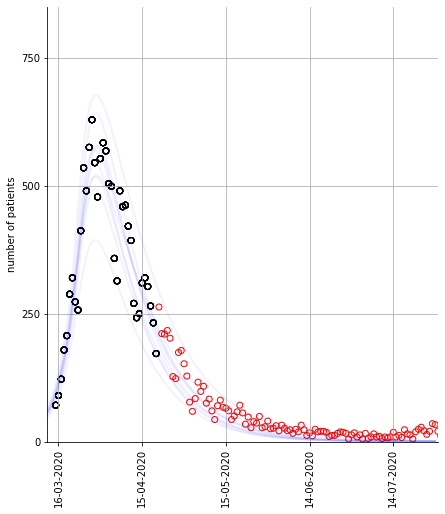

In [122]:
states = [['H_in']]
data=[df_sciensano["H_in"].values[:37]]
T = 100 # extra days to plot model for
end_data = 149#52 end of data tranch to plot
start_date = '15-03-2020'
fig,ax=plt.subplots(figsize=(7,8))
for i in range(10):
    idx,model.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    prevention = samples_dict['prevention'][idx]
    # Create a dictionary of past policies
    chk = {'time':   [lag_time], 
          'Nc':      [prevention*(1.00*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure)]
          }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data,start_date,lag_time,states,T=T,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})

plt.scatter(pd.date_range('15-03-2020',freq='D',periods=df_sciensano["H_in"][37:end_data].size)+datetime.timedelta(days=data[0].size),df_sciensano["H_in"][37:end_data], marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
#leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
ax.set_ylim([0,850])
#plt.savefig('plot_fit_compliance.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

array([ 71,  90, 122, 179, 207, 288, 320, 273, 257, 412, 535, 490, 575,
       629, 545, 478, 553, 584, 568, 504, 499, 358, 314, 490, 459, 462,
       421, 393, 270, 242, 250, 310, 320, 303, 265, 232, 172, 263, 211,
       210, 217, 202, 127, 123, 174, 178, 152, 128,  77,  59,  84, 116,
        98, 108,  75,  83,  60,  43,  70,  81,  67,  65,  60,  43,  50,
        58,  71,  56,  34,  48,  27,  39,  36,  49,  27,  29,  40,  25,
        26,  31,  21,  32,  26,  21,  23,  16,  24,  19,  32,  23,  12,
        17,  11,  24,  19,  20,  20,  18,  10,  12,  12,  16,  19,  18,
        16,   5,  13,  17,   9,  13,   5,  16,   6,   9,  15,   9,  10,
         6,   9,   7,   9,  18,   9,  12,   8,  23,  15,  13,   5,  19,
        24,  28,  21,  14,  20,  35,  33,  20,  11,  26,  23,  24,  18,
        41,  28,  27,  31,  20,  33])

array([ 71,  90, 122, 179, 207, 288, 320, 273, 257, 412, 535, 490, 575,
       629, 545, 478, 553, 584, 568, 504, 499, 358, 314, 490, 459, 462,
       421, 393, 270, 242, 250, 310, 320, 303, 265, 232, 172])

'2020-04-20'

(0, 850)

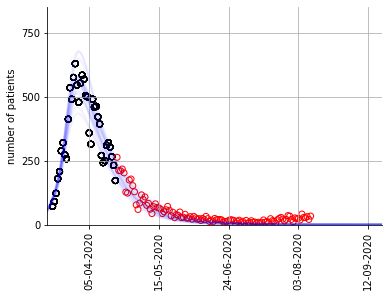

In [129]:
states = [['H_in']]
start_date = '15-03-2020'
end_date = '2020-09-20'
data=[df_sciensano["H_in"].values[:37]]
fig,ax=plt.subplots()
for i in range(20):
    idx,model.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    prevention = samples_dict['prevention'][idx]
    # Create a dictionary of past policies
    chk = {'time':   [lag_time], 
          'Nc':      [prevention*(1.00*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure)]
          }
    y_model = model.sim(time='2020-09-20', excess_time=lag_time,checkpoints=chk)
    ax = plot_fit(y_model,data,start_date,lag_time,states,end_date=end_date,with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})

plt.scatter(pd.date_range('15-03-2020',freq='D',periods=df_sciensano["H_in"][37:end_data].size)+datetime.timedelta(days=data[0].size),df_sciensano["H_in"][37:end_data], marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
#leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
ax.set_ylim([0,850])
#plt.savefig('plot_fit_compliance.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

In [135]:
end_data

149

In [137]:
df_sciensano[:samples_dict['end_ramp']]

,H_tot,ICU_tot,H_in,H_out,H_tot_cumsum,D_tot,D_25_44,D_45_64,D_65_74,D_75_84,D_85+
DATE,,,,,,,,,,,
2020-03-15,266,54,71,18,53,6,0.0,0.0,3,1.0,2
2020-03-16,370,79,90,14,129,11,0.0,0.0,3,3.0,5
2020-03-17,497,100,122,31,220,12,0.0,0.0,1,4.0,7
2020-03-18,650,131,179,48,351,22,1.0,1.0,2,6.0,10
2020-03-19,844,165,207,49,509,28,0.0,0.0,8,5.0,14
2020-03-20,1101,228,288,55,742,31,0.0,4.0,5,4.0,14
2020-03-21,1384,290,320,74,988,39,1.0,3.0,3,16.0,11
2020-03-22,1646,322,273,61,1200,42,1.0,5.0,7,9.0,14
2020-03-23,1883,385,257,60,1397,78,0.0,10.0,8,24.0,26


DATE
2020-04-21    263
2020-04-22    211
2020-04-23    210
2020-04-24    217
2020-04-25    202
             ... 
2020-08-06     28
2020-08-07     27
2020-08-08     31
2020-08-09     20
2020-08-10     33
Freq: D, Name: H_in, Length: 112, dtype: int64

In [134]:
df_sciensano["H_in"][37:end_data]

DATE
2020-04-21    263
2020-04-22    211
2020-04-23    210
2020-04-24    217
2020-04-25    202
             ... 
2020-08-06     28
2020-08-07     27
2020-08-08     31
2020-08-09     20
2020-08-10     33
Freq: D, Name: H_in, Length: 112, dtype: int64

In [138]:
pd.date_range(start_date,freq='D',periods=df_sciensano["H_in"][37:end_data].size)+datetime.timedelta(days=data[0].size)

DatetimeIndex(['2020-04-21', '2020-04-22', '2020-04-23', '2020-04-24',
               '2020-04-25', '2020-04-26', '2020-04-27', '2020-04-28',
               '2020-04-29', '2020-04-30',
               ...
               '2020-08-01', '2020-08-02', '2020-08-03', '2020-08-04',
               '2020-08-05', '2020-08-06', '2020-08-07', '2020-08-08',
               '2020-08-09', '2020-08-10'],
              dtype='datetime64[ns]', length=112, freq='D')

In [ ]:
pd.date_range(

In [139]:
df_sciensano["H_in"][37:end_data]

DATE
2020-04-21    263
2020-04-22    211
2020-04-23    210
2020-04-24    217
2020-04-25    202
             ... 
2020-08-06     28
2020-08-07     27
2020-08-08     31
2020-08-09     20
2020-08-10     33
Freq: D, Name: H_in, Length: 112, dtype: int64

In [144]:
predicted_data = df_sciensano[pd.to_datetime(samples_dict['end_ramp'])+pd.to_timedelta('1d'):end_date]['H_in']


In [148]:
predicted_data.values

array([263, 211, 210, 217, 202, 127, 123, 174, 178, 152, 128,  77,  59,
        84, 116,  98, 108,  75,  83,  60,  43,  70,  81,  67,  65,  60,
        43,  50,  58,  71,  56,  34,  48,  27,  39,  36,  49,  27,  29,
        40,  25,  26,  31,  21,  32,  26,  21,  23,  16,  24,  19,  32,
        23,  12,  17,  11,  24,  19,  20,  20,  18,  10,  12,  12,  16,
        19,  18,  16,   5,  13,  17,   9,  13,   5,  16,   6,   9,  15,
         9,  10,   6,   9,   7,   9,  18,   9,  12,   8,  23,  15,  13,
         5,  19,  24,  28,  21,  14,  20,  35,  33,  20,  11,  26,  23,
        24,  18,  41,  28,  27,  31,  20,  33])

(0, 850)

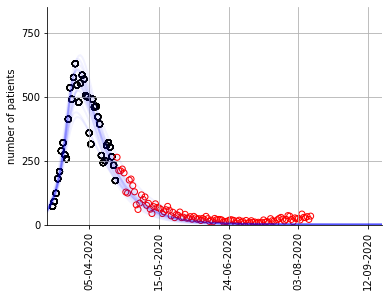

In [149]:
states = [['H_in']]
start_date = '15-03-2020'
end_date = '2020-09-20'
data=[df_sciensano[:samples_dict['end_ramp']]['H_in'].values]
fig,ax=plt.subplots()
for i in range(20):
    idx,model.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    prevention = samples_dict['prevention'][idx]
    # Create a dictionary of past policies
    chk = {'time':   [lag_time], 
          'Nc':      [prevention*(1.00*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure)]
          }
    y_model = model.sim(time='2020-09-20', excess_time=lag_time,checkpoints=chk)
    ax = plot_fit(y_model,data,start_date,lag_time,states,end_date=end_date,with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})

data_after_calib = df_sciensano[pd.to_datetime(samples_dict['end_ramp'])+pd.to_timedelta('1d'):end_date]['H_in']
plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
#leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
ax.set_ylim([0,850])
#plt.savefig('plot_fit_compliance.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

# (Calibration of hospitalization parameters)

Load the previously calibrated parameters: $\beta$, lag_time, k, t0, prevention

In [ ]:
import json
with open('parameters_deterministic.json', 'r') as fp:
    samples_dict = json.load(fp)

lag_time = samples_dict['lag_time']
model.extraTime = samples_dict['lag_time']
model.parameters['beta'] = np.mean(samples_dict['beta'])
model.parameters['l'] = np.mean(samples_dict['l'])
model.parameters['tau'] = np.mean(samples_dict['tau'])
prevention = np.mean(samples_dict['prevention'])

In [ ]:
# Create checkpoints dictionary
chk = {'time':  [lag_time], 
       'Nc':    [prevention*(1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure)],
      }

model.parameters['dICUrec'] = 8

# define dataset
data=[df_sciensano["H_out"].values[:55],df_sciensano["ICU_tot"].values[:55],df_sciensano["H_tot"].values[:55]]
# set optimisation settings
parNames = ['sigma_H_out','sigma_ICU_tot','sigma_H_tot','dc','dICU'] # must be a list!
states = [["H_out"],["ICU"],["H_tot"]]
bounds=((1,200),(1,300),(1,600),(2,30),(2,20)) # must be a list!
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,checkpoints=chk,maxiter=50,popsize=50)

In [ ]:
model.parameters.update({
    'dc': theta[3],
    'dICU': theta[4]
}
)

In [ ]:
T = 3
fig,ax=plt.subplots()
for i in range(1):
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data,'15-03-2020',lag_time,states,T=T,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 1})

In [ ]:
pos = theta + [5,5,5,3,3]* np.random.randn(10, 5)
bounds=((1,500),(1,500),(1,1000),(1,30),(1,30)) 
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames,chk))
sampler.run_mcmc(pos, 16000, progress=True);

In [ ]:
sampler.get_autocorr_time()

In [ ]:
samples = sampler.get_chain(discard=50,flat=False)
flat_samples = sampler.get_chain(discard=50,flat=True)

In [ ]:
mean = np.mean(samples_dict['dICU'])
p10 = np.percentile(samples_dict['dICU'],10)
p90 = np.percentile(samples_dict['dICU'],90)
print(mean,p10,p90)

In [ ]:
samples_dict.update({'dc': flat_samples[:,3].tolist(), 'dICU': flat_samples[:,4].tolist()})

In [ ]:
traceplot(samples=sampler.get_chain(discard=50),labels=["sigma_H_out","sigma H_tot","sigma_ICU_tot","dc","dICU"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

In [ ]:
import corner

fig = corner.corner(
    flat_samples, labels=["sigma_H_out","sigma H_tot","sigma_ICU_tot","dc","dICU"],
);
fig.set_size_inches(12, 12)
plt.savefig('corner_compliance_hospitalization.pdf', dpi=600, bbox_inches='tight',
                    orientation='portrait', papertype='a4')

In [ ]:
T = 21

fig,ax=plt.subplots()
for i in range(300):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    model.parameters['l'] = np.random.choice(samples_dict['l'],1,replace=False)
    prevention = np.random.choice(samples_dict['prevention'],1,replace=False)
    model.parameters['dc'] = np.random.choice(samples_dict['dc'],1,replace=False)
    model.parameters['dICU'] = np.random.choice(samples_dict['dICU'],1,replace=False)
    # Create checkpoints dictionary
    chk = {'time':  [lag_time], 
           'Nc':    [prevention*(1.3*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure)],
      }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data,'15-03-2020',lag_time,states,T=T,ax=ax,
                  legend_text=['Hospital discharges','Intensive care units (total)','Hospitals (total)'],
                  plt_kwargs={'linewidth': 0.10,'alpha': 0.15})

In [ ]:
import json

with open('parameters_deterministic.json', 'w') as fp:
    json.dump(samples_dict, fp)

In [ ]:
R_0 =[]
for i in range(len(samples_dict['beta'])):
    R_0.append(sum((model.parameters['a']*model.parameters['da']+model.parameters['omega'])*samples_dict['beta'][i]*model.parameters['s']*np.sum(Nc_total,axis=1)*(initN/sum(initN))))

plt.hist(R_0,bins=30)
mean = np.mean(R_0)
p10 = np.percentile(R_0,10)
p90 = np.percentile(R_0,90)
print(mean,p10,p90)

In [ ]:
R_0 = np.zeros([initN.size,len(samples_dict['beta'])])
for i in range(len(samples_dict['beta'])):
    R_0[:,i]= (model.parameters['a']*model.parameters['da']+model.parameters['omega'])*samples_dict['beta'][i]*model.parameters['s']*np.sum(Nc_total,axis=1)
plt.hist(R_0[8,:],bins=30)

for i in range(R_0.shape[0]):
    mean = np.mean(R_0[i,:])
    p10 = np.percentile(R_0[i,:],10)
    p90 = np.percentile(R_0[i,:],90)
    print(mean,p10,p90)

# Notebook works till here

### Scenarios

In [ ]:
import json
with open('parameters_deterministic.json', 'r') as fp:
    samples_dict = json.load(fp)

lag_time = samples_dict['lag_time']
model.extraTime = samples_dict['lag_time']
model.parameters['beta'] = np.mean(samples_dict['beta'])
model.parameters['l'] = np.mean(samples_dict['l'])
model.parameters['tau'] = np.mean(samples_dict['tau'])
prevention = np.mean(samples_dict['prevention'])

In [ ]:
import random
from covid19model.visualization.output import _apply_tick_locator

# define dataset
data=[df_sciensano["H_in"].values[:51]]
states = [["H_in"]]
start_date = '15-03-2020'

T = 2

fig,ax=plt.subplots()
for i in range(300):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    prevention = samples_dict['prevention'][idx]
    #idx,model.parameters['dc'] = random.choice(list(enumerate(samples_dict['dc'])))
    #model.parameters['dICU'] = samples_dict['dICU'][idx]
    # Create a dictionary of past policies
    chk = {'time':   [lag_time], 
          'Nc':      [prevention*(1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure)]
          }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    
    # Create shifted index vector 
    idx = pd.date_range(start_date,freq='D',periods=data[0].size + lag_time + T) - datetime.timedelta(days=lag_time)
    # Plot model prediction

    lines = ax.plot([],[],color='red',alpha=1)
    lines = ax.plot([],[],color='blue',alpha=1)
    
    for i in range(len(data)):
        # ages 60 plus
        #data2plot = y_model[states[i]].to_array(dim="states").values.ravel()
        #val = y_model[states[i]].to_array(dim="states").values[:,6:,:].sum(axis=1)
        #csum=np.cumsum(val)
        #lines = ax.plot(idx,csum,color='green',linewidth= 2,alpha= 0.05)    
        # ages 70 plus
        data2plot = y_model[states[i]].to_array(dim="states").values.ravel()
        val = y_model[states[i]].to_array(dim="states").values[:,7:,:].sum(axis=1)
        csum=np.cumsum(val)
        lines = ax.plot(idx,csum,color='blue',linewidth= 2,alpha= 0.05)    
        # total cumsum
        data2plot = y_model[states[i]].to_array(dim="states").values.ravel()
        val = y_model[states[i]].to_array(dim="states").values.sum(axis=1)
        csum=np.cumsum(val)
        lines = ax.plot(idx,csum,color='red',linewidth= 2,alpha= 0.05)  
    # Plot data
    for i in range(len(data)):
        lines=ax.scatter(idx[lag_time:-T],np.cumsum(data[i]),color="black",facecolors='none')
    

    # Attributes
    #if legend_text is not None:
    #    leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
    #if titleText is not None:
    #    ax.set_title(titleText,{'fontsize':18})

    # Format axes
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    plt.setp(plt.gca().xaxis.get_majorticklabels(),
        'rotation', 90)
    #fig.autofmt_xdate(rotation=90)
    ax.set_xlim( idx[lag_time-3], pd.to_datetime(idx[-1]+ datetime.timedelta(days=1)))
    ax.set_ylabel('number of patients')

    # limit the number of ticks on the axis
    ax = _apply_tick_locator(ax)

legend_text=['Total hospitalizations','Total hospitalizations \n(ages 70+)']
leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
for lh in leg.get_lines(): 
    lh.set_alpha(1)
fig.set_size_inches(10, 4)
plt.savefig('hospital_age.pdf', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')

In [ ]:
data=[df_sciensano["H_tot"].values[:],df_sciensano["ICU_tot"].values[:]]
states = [["H_tot"],["ICU"]]

In [ ]:
T = 62
# Define data as a list containing data timeseries
index = pd.date_range('15-03-2020',freq='D',periods=data[0].size + lag_time + T)
print(index[1],index[50],index[52],index[57],index[64],index[81],index[108],index[170])

In [ ]:
T = 62

fig,ax=plt.subplots()

ax.axvspan(index[50], index[64], alpha=0.20, color='black')
ax.axvspan(index[64], index[81], alpha=0.10, color='black')
ax.axvspan(index[81], index[-1], alpha=0.05, color='black')

for i in range(300):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    prevention = samples_dict['prevention'][idx]
    #model.parameters['dc'] = np.random.choice(samples_dict['dc'],1,replace=False)
    #model.parameters['dICU'] = np.random.choice(samples_dict['dICU'],1,replace=False)
    # Create a dictionary of past policies
    chk = {'time':   [lag_time,lag_time+50,lag_time+52,lag_time+57,lag_time+64,lag_time+81,lag_time+108], 
          'Nc':      [prevention*(1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.50)*Nc_work + (1-0.60)*Nc_transport + (1-0.30)*Nc_others + (1-0.70)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.40)*Nc_work + (1-0.55)*Nc_transport + (1-0.25)*Nc_others + (1-0.65)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.30)*Nc_work + (1-0.50)*Nc_transport + (1-0.20)*Nc_others + (1-0.60)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.30)*Nc_work + (1-0.45)*Nc_transport + (1-0.85)*Nc_schools + (1-0.15)*Nc_others + (1-0.50)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.25)*Nc_work + (1-0.35)*Nc_transport + (1-0.35)*Nc_schools + (1-0.10)*Nc_others + (1-0.30)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.20)*Nc_work + (1-0.15)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_leisure)]
                  }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data,'15-03-2020',lag_time,states,T=T,ax=ax,
                  legend_text=None,
                  plt_kwargs={'linewidth': 2,'alpha': 0.05})

legend_text=['Hospital (total)','ICU (total)']
leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
for lh in leg.get_lines(): 
    lh.set_alpha(1)
#fig.set_size_inches(10, 4)
plt.savefig('lockdown_release.pdf', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')

In [ ]:
T = 3

fig,ax=plt.subplots()

for i in range(200):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    prevention = samples_dict['prevention'][idx]
    #model.parameters['dc'] = np.random.choice(samples_dict['dc'],1,replace=False)
    #model.parameters['dICU'] = np.random.choice(samples_dict['dICU'],1,replace=False)
    # Create a dictionary of past policies
    chk = {'time':   [lag_time], 
          'Nc':      [prevention*(1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure),
                     ]
                  }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data,'15-03-2020',lag_time,states,T=T,ax=ax,
                  legend_text=None,
                  plt_kwargs={'linewidth': 2,'alpha': 0.05})

legend_text=['Hospital (total)','ICU (total)']
#leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
#for lh in leg.get_lines(): 
#    lh.set_alpha(1)
#fig.set_size_inches(6, 4)
plt.savefig('continued_lockdown.pdf', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')

In [ ]:
fig,ax=plt.subplots()
for i in range(300):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    model.parameters['l'] = np.random.choice(samples_dict['l'],1,replace=False)
    prevention = np.random.choice(samples_dict['prevention'],1,replace=False)
    #model.parameters['dc'] = np.random.choice(samples_dict['dc'],1,replace=False)
    #model.parameters['dICU'] = np.random.choice(samples_dict['dICU'],1,replace=False)
    # Create a dictionary of past policies
    chk = {'time':   [lag_time,lag_time+50,lag_time+52,lag_time+57], 
          'Nc':      [prevention*(1.3*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure),
                      prevention*(1.2*Nc_home + (1-0.50)*Nc_work + (1-0.60)*Nc_transport + (1-0.30)*Nc_others + (1-0.70)*Nc_leisure),
                      prevention*(1.1*Nc_home + (1-0.40)*Nc_work + (1-0.55)*Nc_transport + (1-0.25)*Nc_others + (1-0.65)*Nc_leisure),
                      prevention*(Nc_home + (1-0.30)*Nc_work + (1-0.50)*Nc_transport + (1-0.20)*Nc_others + (1-0.60)*Nc_leisure),]
                              #0.2*Nc_home + prevention*((1-0.30)*Nc_work + (1-0.45)*Nc_transport + (1-0.85)*Nc_schools + (1-0.15)*Nc_others + (1-0.50)*Nc_leisure),
                              #0.2*Nc_home + prevention*((1-0.25)*Nc_work + (1-0.35)*Nc_transport + (1-0.35)*Nc_schools + (1-0.10)*Nc_others + (1-0.30)*Nc_leisure),
                              #0.2*Nc_home + prevention*((1-0.20)*Nc_work + (1-0.15)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_leisure)]
                  }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    #ax.plot(1-y_model["S"][:,lag_time+15]/y_model["S"][:,0],alpha=0.2,color='blue',linewidth=0.1)
    ax.plot(1-y_model["S"][:,lag_time+36]/y_model["S"][:,0],alpha=0.2,color='red',linewidth=2)
ax.set_xlabel('age group 0 to 80+')
ax.set_ylabel("fraction 'immune'" )

### Re-estimating beta

In [ ]:
samples_dict.keys()

In [ ]:
T = 62
from copy import deepcopy
# Create checkpoints dictionary
# checkpoints are hardcoded!
# Create a dictionary of past policies
chk = {'time':   [lag_time,lag_time+50,lag_time+52,lag_time+57,lag_time+64,lag_time+81,lag_time+108], 
        'Nc':    [prevention*(1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure),
                  prevention*(1.0*Nc_home + (1-0.50)*Nc_work + (1-0.60)*Nc_transport + (1-0.30)*Nc_others + (1-0.70)*Nc_leisure),
                  prevention*(1.0*Nc_home + (1-0.40)*Nc_work + (1-0.55)*Nc_transport + (1-0.25)*Nc_others + (1-0.65)*Nc_leisure),
                  prevention*(1.0*Nc_home + (1-0.30)*Nc_work + (1-0.50)*Nc_transport + (1-0.20)*Nc_others + (1-0.60)*Nc_leisure),
                  prevention*(1.0*Nc_home + (1-0.30)*Nc_work + (1-0.45)*Nc_transport + (1-0.85)*Nc_schools + (1-0.15)*Nc_others + (1-0.50)*Nc_leisure),
                  prevention*(1.0*Nc_home + (1-0.25)*Nc_work + (1-0.35)*Nc_transport + (1-0.35)*Nc_schools + (1-0.10)*Nc_others + (1-0.30)*Nc_leisure),
                  prevention*(1.0*Nc_home + (1-0.20)*Nc_work + (1-0.15)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_leisure)],
        'beta': [np.random.choice(samples_dict['beta'],1,replace=False),
                   0.01,
                   0.01,
                   0.01,
                   0.01,
                   0.01,
                   0.01,]
      }


# define dataset
data=[df_sciensano["H_in"].values[50:]]
# Redine lag_time
model.extraTime = lag_time+50
# define samples_dict without lag_time
smpls=deepcopy(samples_dict)
del smpls['lag_time']
# set optimisation settings
parNames = ['sigma_H_in','beta'] # must be a list!
states = [["H_in"]]
bounds=((1,500),(0.001,0.04)) # must be a list!

In [ ]:
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,checkpoints=chk,samples=smpls,maxiter=50,popsize=20)

In [ ]:
parNames = ['sigma_ICU','beta'] # must be a list!
bounds=((1,200),(0.0001,0.10))

pos = [theta[0],theta[1]] + [1, 1e-2 ]* np.random.randn(8, 2)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames,chk,smpls))
sampler.run_mcmc(pos, 12000, progress=True);

In [ ]:
samples = sampler.get_chain(discard=500,flat=False)
flat_samples = sampler.get_chain(discard=500,flat=True)

In [ ]:
sampler.get_autocorr_time()

In [ ]:
mean = np.mean(flat_samples[:,1])
p10 = np.percentile(flat_samples[:,1],10)
p90 = np.percentile(flat_samples[:,1],90)
print(mean,p10,p90)

In [ ]:
traceplot(samples,labels=["sigma2_ICU","beta"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

In [ ]:
import corner

fig = corner.corner(
    flat_samples,labels=['$\sigma_{data}$','$\\beta$']
);
fig.set_size_inches(8, 8)
plt.savefig('corner_beta.pdf', dpi=600, bbox_inches='tight',
                    orientation='portrait', papertype='a4')

In [ ]:
# define dataset
data=[df_sciensano["H_tot"].values[:],df_sciensano["ICU_tot"].values[:]]
states = [["H_tot"],["ICU"]]

In [ ]:
T = 1
start_date='15-03-2020'
#data=[df_sciensano["H_in"].values[:]]

fig,ax=plt.subplots()
for i in range(10):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    prevention = samples_dict['prevention'][idx]
    # Create a dictionary of past policies
    chk = {'time':   [lag_time,lag_time+50,lag_time+52,lag_time+57,lag_time+64,lag_time+81,lag_time+108], 
            'Nc':    [prevention*(1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.50)*Nc_work + (1-0.60)*Nc_transport + (1-0.30)*Nc_others + (1-0.70)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.40)*Nc_work + (1-0.55)*Nc_transport + (1-0.25)*Nc_others + (1-0.65)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.30)*Nc_work + (1-0.50)*Nc_transport + (1-0.20)*Nc_others + (1-0.60)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.30)*Nc_work + (1-0.45)*Nc_transport + (1-0.85)*Nc_schools + (1-0.15)*Nc_others + (1-0.50)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.25)*Nc_work + (1-0.35)*Nc_transport + (1-0.35)*Nc_schools + (1-0.10)*Nc_others + (1-0.30)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.20)*Nc_work + (1-0.15)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_leisure)],
            'beta': [np.random.choice(samples_dict['beta'],1,replace=False),
                       theta[1],
                       theta[1],
                       theta[1],
                       theta[1],
                       theta[1],
                       theta[1]
                    ]
          }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data,start_date,lag_time,states,T=T,ax=ax,plt_kwargs={'linewidth': 2,'alpha': 0.05})
    
#plt.scatter(pd.date_range('15-03-2020',freq='D',periods=df_sciensano["H_in"][:50].size),df_sciensano["H_in"][:50], marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
plt.savefig('plot_fit_beta.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

In [ ]:
R_0 = (model.parameters['a']*model.parameters['da']+model.parameters['omega'])*mean*model.parameters['s']*np.sum(Nc_total,axis=1)

In [ ]:
print(R_0,np.mean(R_0))